In [2]:
import random


def generate_random_colors(n, seed=42):
    random.seed(seed)
    colors = []
    for _ in range(n):
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        colors.append(color)
    return colors

In [3]:
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display


class FloorPlan:
    GRID_UNIT_SIZE = 1.00  # 单位m
    GRID_AREA = GRID_UNIT_SIZE ** 2  # 单元格面积
    GRID_NUM_X = 40
    GRID_NUM_Y = 32
    NUM_LAYERS = 3  # 观察空间深度/层数
    VALID_LAYER = 0  # 第1层为是否可以填充
    TYPE_LAYER = 1  # 第2层为房间类型层，0为保留的未定义类型，房间类型序号从1开始
    IDX_LAYER = 2  # 第3层为序号层， 0 为保留的未定义序号，房间序号从1开始

    @staticmethod
    def get_empty_mask() -> np.ndarray:
        """获取空蒙版"""
        return np.zeros(shape=(FloorPlan.GRID_NUM_Y, FloorPlan.GRID_NUM_X), dtype=bool)
    @staticmethod
    def set_mask_value(mask, x_range, y_range, value):
        """设置mask中某一范围的值"""
        mask[y_range[0]:y_range[1], x_range[0]: x_range[1]] = value
    
    def __init__(self, plan_mask: np.ndarray):
        self.num_x = FloorPlan.GRID_NUM_X
        self.num_y = FloorPlan.GRID_NUM_Y
        self.grid = np.zeros(shape=(self.num_y, self.num_x, FloorPlan.NUM_LAYERS), dtype=np.uint8)  # unit8决定了最多支持256种房间类型，最多256个房间
        self.grid_coord = np.stack(np.meshgrid(np.arange(self.num_x), np.arange(self.num_y)), axis=-1)  # (num_y, num_x, 2)其中最后一维为x和y坐标
        self.plan_mask = plan_mask
        self._set_valid_by_mask(self.plan_mask, True)

    def _set_valid_by_mask(self, mask: np.ndarray, value: bool) -> None:
        self.grid[mask] = value

    def _set_type(self, x_range: tuple[int, int], y_range: tuple[int, int], value: int) -> None:
        self.grid[y_range[0]:y_range[1], x_range[0]: x_range[1], FloorPlan.TYPE_LAYER] = value

    def _set_type_by_mask(self, mask: np.ndarray, value: int) -> None:
        self.grid[mask] = value

    def _set_idx(self, x_range: tuple[int, int], y_range: tuple[int, int], value: int) -> None:
        self.grid[y_range[0]:y_range[1], x_range[0]: x_range[1], FloorPlan.IDX_LAYER] = value

    def _set_idx_by_mask(self, mask: np.ndarray, value: int) -> None:
        self.grid[mask] = value

    def create_room(self, x_range: tuple[int, int], y_range: tuple[int, int], room_type: int, room_idx: int) -> float:
        """创建房间"""
        # 计算重叠面积
        org_room_mask = self.grid[:, :, FloorPlan.TYPE_LAYER] != 0
        new_room_mask = np.zeros(shape=(self.num_y, self.num_x), dtype=bool)
        new_room_mask[y_range[0]:y_range[1], x_range[0]: x_range[1]] = True
        overlay_mask = org_room_mask & new_room_mask  # 计算原有的房间区域和新建的房间区域的重叠mask
        overlay_area = np.sum(overlay_mask) * FloorPlan.GRID_AREA  # 计算重叠区域面积

        self._set_type(x_range, y_range, room_type)  # 这里的操作会覆盖原有的信息
        self._set_idx(x_range, y_range, room_idx)

        return overlay_area

    def get_valid(self, x, y) -> bool:
        return bool(self.grid[y, x, FloorPlan.VALID_LAYER])

    def get_type(self, x, y) -> int:
        return self.grid[y, x, FloorPlan.TYPE_LAYER]

    def get_idx(self, x, y) -> int:
        return self.grid[y, x, FloorPlan.IDX_LAYER]

    def get_room_area_by_type(self, room_type):
        """获取某一类型房间的总面积"""
        return np.sum(self.grid[:, :, FloorPlan.TYPE_LAYER] == room_type) * FloorPlan.GRID_AREA

    def get_total_room_area(self):
        """房间总面积"""
        return np.sum(self.grid[:, :, FloorPlan.TYPE_LAYER] != 0) * FloorPlan.GRID_AREA

    def get_invalid_room_area(self):
        # 获取超出有效区域的room的面积，即无效区域但是有room type的
        non_plan_mask = self.grid[:, :, FloorPlan.VALID_LAYER] == 0
        room_mask = self.grid[:, :, FloorPlan.TYPE_LAYER] != 0
        return np.sum(non_plan_mask & room_mask) * FloorPlan.GRID_AREA

    def get_plan_area(self):
        """建筑平面总面积"""
        return np.sum(self.grid[:, :, FloorPlan.VALID_LAYER != 0]) * FloorPlan.GRID_AREA

    def draw(self):
        # settings
        PIXEL_PER_GRID = 10
        COLOR_SEED = 1

        UNDEFINED_VALID_COLOR = (200, 200, 200)  # valid 且 type = 0 的颜色，默认为灰色，表示没有赋值
        # 白色
        white = np.array([255, 255, 255])

        # create canvas
        canvas = Image.new('RGB', (self.num_x * PIXEL_PER_GRID, self.num_y * PIXEL_PER_GRID), 'white')
        draw = ImageDraw.Draw(canvas)

        # get color for type
        max_type = np.max(self.grid[:, :, FloorPlan.TYPE_LAYER])
        colors_arr = np.array([UNDEFINED_VALID_COLOR] + generate_random_colors(max_type, seed=COLOR_SEED))
        grid_colors = colors_arr[self.grid[:, :, FloorPlan.TYPE_LAYER]]  # (num_y, num_x, 3)

        # get grid coord
        top_left = self.grid_coord * PIXEL_PER_GRID  # (num_y, num_x, 2) in pixel
        bot_right = (self.grid_coord + 1) * PIXEL_PER_GRID  # (num_y, num_x, 2) in pixel

        for y in range(self.num_y):
            for x in range(self.num_x):
                xyxy = (top_left[y, x, 0], top_left[y, x, 1], bot_right[y, x, 0], bot_right[y, x, 1])
                valid = self.get_valid(x, y)
                room_type = self.get_type(x, y)
                if valid:
                    if room_type:
                        # valid and room type
                        draw.rectangle(xyxy, outline='gray', fill=tuple(grid_colors[y, x]))
                    else:
                        # valid and no room type
                        draw.rectangle(xyxy, outline='gray', fill=UNDEFINED_VALID_COLOR)
                else:
                    if room_type:
                        # not valid and room type
                        draw.rectangle(xyxy, outline='gray', fill=tuple(np.array(0.5 * grid_colors[y, x] + 0.5 * white, dtype=np.uint8)))
                    else:
                        # not valid and no room type
                        draw.rectangle(xyxy, outline='gray', fill=None)

        # 在Jupyter Notebook中显示图像
        display(canvas)




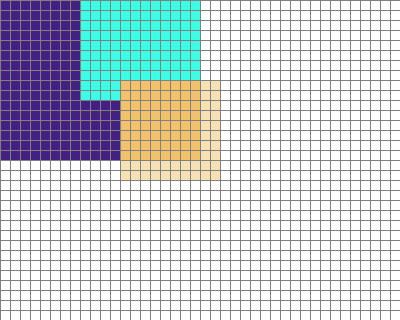

In [5]:
plan_mask = FloorPlan.get_empty_mask()
FloorPlan.set_mask_value(plan_mask, (0, 20), (0, 16), True)
fp = FloorPlan(plan_mask)
fp.create_room((0, 10), (0, 12), room_type=1, room_idx=1)
fp.create_room((8, 20), (0, 10), room_type=2, room_idx=2)
fp.create_room((12, 22), (8, 18), room_type=3, room_idx=3)
fp.draw()

100.0
36.0


In [12]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian(x, mu, sigma, min_value=0, max_value=1):
    """
    高斯函数


    :param x: 自变量
    :param mu: 均值（mean）
    :param sigma: 标准差（standard deviation）
    :param min_value: 函数最小值
    :param max_value: 函数最大值
    :return: 高斯函数值
    """
    coefficient = 1 / (sigma * np.sqrt(2 * np.pi))
    exponent = -((x - mu) ** 2) / (2 * sigma ** 2)
    value = coefficient * np.exp(exponent) / coefficient
    value = value * (max_value - min_value) + min_value
    return value


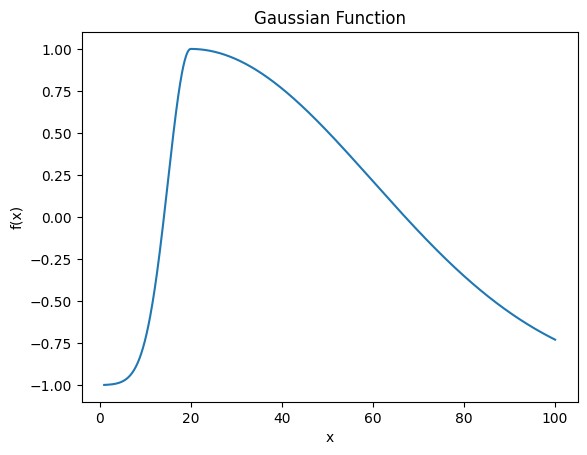

In [17]:

def area_reward(x):
    if x < 20:
        return gaussian(x, 20,5, -1, 1)
    else:
        return gaussian(x, 20, 40, -1, 1)
x = np.linspace(1, 100, 1000)
y = [area_reward(i) for i in x]

# 绘制高斯函数
plt.plot(x, y)
plt.title('Gaussian Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [1]:
import streamlit_authenticator as stauth

AttributeError: module 'streamlit_authenticator' has no attribute 'Hasher'